# Asset Returns Analysis

This notebook analyzes various property investment scenarios, comparing returns on property investments versus stock market investments (represented by BRK.B stock).

Key analyses include:
- Property investment returns with different rental scenarios
- Opportunity cost comparisons between property and stocks
- Employment income and savings calculations

In [1]:
# Standard library imports
import numpy as np
import pandas as pd

# Third-party imports
import plotly.express as px
from tabulate import tabulate

# Local imports
from assetreturns import (
    generateLeaseholdPropertyForecast,
    mortgageFactory,
    TaxDeductibleMortgage,
    RepaymentMortgage,
    InterestOnlyMortgage,
    HLStock,
    calculateSDLT,
    LeaseholdProperty
)


def generate_header_table_and_graph_source(
    asset_dict, years_to_forecast=50, inflation_rate=0.01
):
    """
    Generate table and graph data for asset performance analysis.
    
    Args:
        asset_dict: Dictionary of asset names to asset objects
        years_to_forecast: Number of years to project (default: 50)
        inflation_rate: Annual inflation rate (default: 0.01)
    
    Returns:
        tuple: (headers, table, graph_source) where:
            - headers: List of column headers
            - table: List of rows for the summary table
            - graph_source: DataFrame with time-series data for graphing
    """
    headers = [
        "Asset Name",
        "Initial Equity Cost",
        "Nominal ROI",
        "% ROI",
        "% ROI Year on Year",
        "Nominal Profit"
    ]
    table = []
    
    graph_source = pd.DataFrame(
        index=np.arange(0, years_to_forecast * len(asset_dict)),
        columns=[
            "Asset Name",
            "Year",
            "Nominal ROI",
            "% ROI Year on Year",
            "% ROI",
            "Nominal Profit"
        ]
    )
    
    j = 0
    for key, value in asset_dict.items():
        for i in range(0, years_to_forecast):
            years = i + 1
            
            if years == 1:
                roi_this_year = value.percentage_return_on_investment(
                    years, inflation_rate, 0
                )
                profit_this_year = value.calculate_profits(years)
            else:
                roi_this_year = (
                    value.percentage_return_on_investment(years, inflation_rate, 0)
                    - value.percentage_return_on_investment(years - 1, inflation_rate, 0)
                )
                profit_this_year = (
                    value.calculate_profits(years)
                    - value.calculate_profits(years - 1)
                )
            
            graph_source.loc[j + i] = [
                key,
                years,
                value.nominal_return_on_investment(years, inflation_rate, 0),
                value.annual_percentage_return_on_investment(years, inflation_rate, 0),
                roi_this_year,
                profit_this_year
            ]
            
            row = [
                key,
                value.initial_equity_cost,
                value.nominal_return_on_investment(25, 0, 0),
                value.percentage_return_on_investment(25, 0.01, 0),
                value.annual_percentage_return_on_investment(25, inflation_rate, 0),
                profit_this_year
            ]
        
        table.append(row)
        j += years_to_forecast
    
    return headers, table, graph_source


if __name__ == "__main__":
    # Configuration
    LTV_PERCENTAGE = 0.75
    INTEREST_RATE = 0.0259
    LIXING_AGENCY_PERCENTAGE = (0.075 + 0.025) * 1.20
    
    asset_dictionary = {}
    
    # Cookham House property
    property_forecast = generateLeaseholdPropertyForecast(
        True,
        750000,
        ltv_percentage=LTV_PERCENTAGE,
        monthly_gross_rental=(700 + 700 * 3),
        rental_tax=0.45,
        months_occupied_out_of_12=10,
        agency_percentage=0.2,
        annual_service_charge=1500,
        annual_ground_rent=90,
        mortgage_searcher=mortgageFactory,
        MortgageClass=TaxDeductibleMortgage,
        MortgageClassToDecorate=RepaymentMortgage,
        tax_rate=0.2,
        length=25,
        interest_rate=INTEREST_RATE
    )
    asset_dictionary["Cookham House"] = property_forecast
    
    # 2 Bed 1 bath property
    asset_dictionary["2 Bed 1 bath long and waterson"] = generateLeaseholdPropertyForecast(
        True,
        690000,
        ltv_percentage=LTV_PERCENTAGE,
        monthly_gross_rental=625,
        rental_tax=0,
        months_occupied_out_of_12=12,
        agency_percentage=LIXING_AGENCY_PERCENTAGE,
        annual_service_charge=7 * 677,
        annual_ground_rent=600,
        mortgage_searcher=mortgageFactory,
        MortgageClass=RepaymentMortgage,
        length=25,
        interest_rate=INTEREST_RATE
    )
    
    # Heron Studio property
    heron_property_price = 600000
    asset_dictionary["Heron - Studio"] = generateLeaseholdPropertyForecast(
        True,
        heron_property_price,
        ltv_percentage=LTV_PERCENTAGE,
        monthly_gross_rental=0,
        rental_tax=0,
        months_occupied_out_of_12=10,
        agency_percentage=0,
        annual_service_charge=3967,
        annual_ground_rent=300,
        mortgage_searcher=mortgageFactory,
        MortgageClass=RepaymentMortgage,
        length=25,
        interest_rate=INTEREST_RATE
    )
    
    # Generate summary table
    (headers, table, graph_source) = generate_header_table_and_graph_source(
        asset_dictionary
    )
    print(tabulate(table, headers, tablefmt="presto"))
    
    # Configuration for subsequent analyses
    stock_price_to_earnings = 35
    cost_of_renting_alone = 2700
    atlas_fully_rented_out = 3067
    atlas_studio_property_price = 550000
    
    # Remove properties for specific analyses
    del asset_dictionary["2 Bed 1 bath long and waterson"]
    del asset_dictionary["Cookham House"]
    del asset_dictionary["Heron - Studio"]

 Asset Name                     |   Initial Equity Cost |   Nominal ROI |   % ROI |   % ROI Year on Year |   Nominal Profit
--------------------------------+-----------------------+---------------+---------+----------------------+------------------
 Cookham House                  |                187500 |        572431 | 3.88473 |            0.0655005 |             9800
 2 Bed 1 bath long and waterson |                172501 |        425726 | 3.30133 |            0.0600933 |             6600
 Heron - Studio                 |                150001 |        227253 | 2.35138 |            0.049564  |                0


In [2]:
# Employment income parameters
MONTHS_EMPLOYED = 60
INITIAL_BALANCE = 50000
NET_MONTHLY_SALARY = 7000
BONUS_MONTH = 12
NET_YEARLY_BONUS = 10000
MONTHLY_COST_OF_LIVING = 4000

# Calculate savings over time
employment_income = pd.DataFrame(
    index=np.arange(0, MONTHS_EMPLOYED),
    columns=["Net Income", "Balance"]
)
employment_income["Net Income"].values[:] = 0
employment_income["Balance"].values[:] = 0

# First month
first_row = employment_income.loc[0]
first_row["Net Income"] = NET_MONTHLY_SALARY - MONTHLY_COST_OF_LIVING
first_row["Balance"] = INITIAL_BALANCE + first_row["Net Income"]

# Subsequent months
for i in range(1, MONTHS_EMPLOYED):
    row = employment_income.loc[i]
    row["Net Income"] = NET_MONTHLY_SALARY - MONTHLY_COST_OF_LIVING
    
    # Add bonus every 12 months
    if (i + 1) % BONUS_MONTH == 0:
        row["Net Income"] += NET_YEARLY_BONUS
    
    previous_balance = employment_income.loc[i - 1]["Balance"]
    row["Balance"] = previous_balance + row["Net Income"]

print(employment_income.tail(3))

# Calculate maximum property price with mortgage
FIXED_INTEREST_RATE = 0.0319
repayment_mortgage = RepaymentMortgage(
    540000,
    25,
    FIXED_INTEREST_RATE,
    {1 * 12: 0.1, 2 * 12: 0.1, 3 * 12: 0.1, 4 * 12: 0.1, 5 * 12: 1}
)
print(f"Total payments / 0.75 LTV: {repayment_mortgage.total_payments(25) / 0.75:.2f}")

   Net Income Balance
57       3000  264000
58       3000  267000
59      13000  280000
Total payments / 0.75 LTV: 805221.47


## Employment Income and Savings Calculator

Calculate potential savings over time based on salary, bonuses, and living expenses.

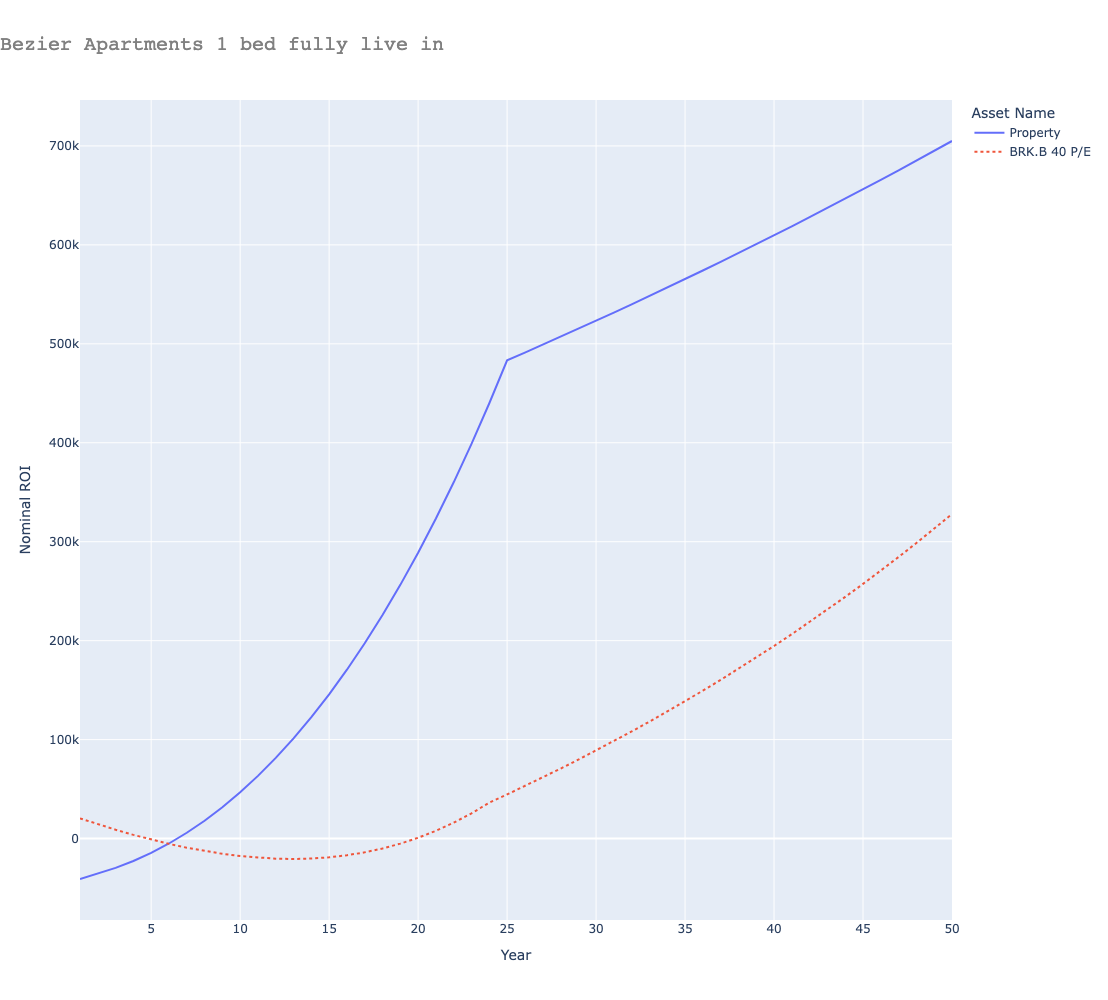

In [3]:
# Bezier Apartments 1 bed fully live in
property_price = 850000
repayment_mortgage = RepaymentMortgage(
    property_price * 0.75,
    25,
    FIXED_INTEREST_RATE
)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(
    False,
    property_price,
    monthly_gross_rental=0,
    rental_tax=0,
    months_occupied_out_of_12=8,
    agency_percentage=LIXING_AGENCY_PERCENTAGE,
    annual_service_charge=7 * 677,
    annual_ground_rent=600,
    mortgage=repayment_mortgage
)

opportunity_cost_property = asset_dictionary[asset_name]

# Calculate yearly principle repayments with opportunity cost
yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)

for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(
        current_year - previous_year - cost_of_renting_alone * 12
    )
    previous_year = current_year

asset_dictionary["BRK.B 40 P/E"] = HLStock(
    opportunity_cost_property.property_value * 0.25,
    stock_price_to_earnings,
    yearly_principle_repayments
)

# Generate visualization
(headers, table, graph_source) = generate_header_table_and_graph_source(
    asset_dictionary
)

fig = px.line(
    graph_source,
    x='Year',
    y='Nominal ROI',
    color='Asset Name',
    line_dash='Asset Name',
    title='Bezier Apartments 1 bed fully live in',
    width=1000,
    height=1000
)

fig.update_layout(
    title_font_size=20,
    title_font_family='Courier',
    title_font_color='gray',
    title_x=0
)

fig.show()

## Property Investment Analysis

Comparative analysis of various property investment scenarios, comparing property returns against stock market investments (BRK.B).

[np.float64(21065.974478804204), np.float64(-10662.02093532195), np.float64(-9968.57940315875), np.float64(-9253.017086119507), np.float64(-8514.628331166692), np.float64(-7752.684974930875), np.float64(-6966.4356256311585), np.float64(-6155.104922088794), np.float64(-5317.892769103404), np.float64(-4453.973548437731), np.float64(-3562.495304632961), np.float64(-2642.5789048504084), np.float64(-1693.3171719147358), np.float64(-713.7739896987914), np.float64(297.01662002975354), np.float64(1340.0514502086444), np.float64(2416.359091470251), np.float64(3527.000946488115), np.float64(4673.0722766810795), np.float64(5855.703282307368), np.float64(7076.060217012768), np.float64(8335.346537935431), np.float64(9634.804092495702), np.float64(10975.714343046304)]


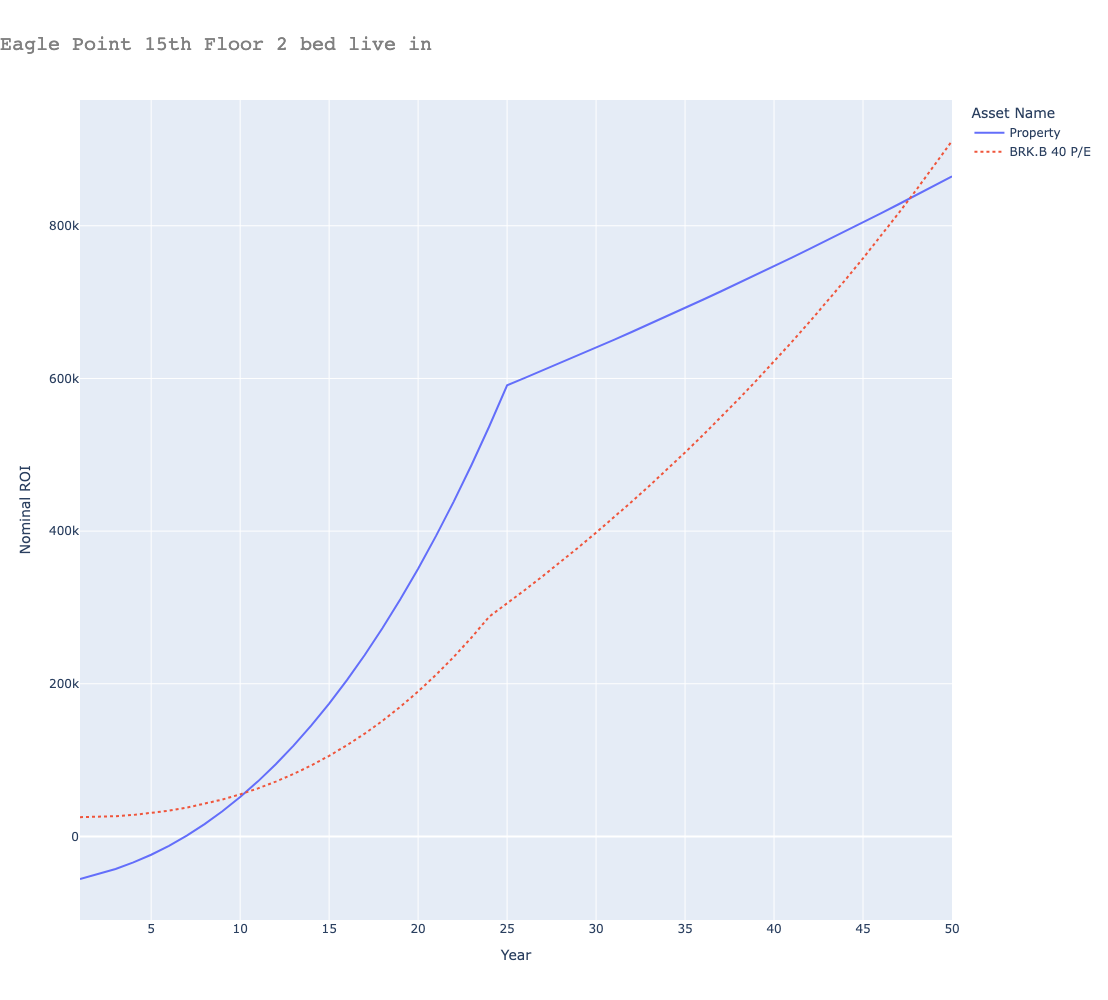

In [4]:
# Eagle Point 15th Floor 2 bed live in
property_price = 1050000
repayment_mortgage = RepaymentMortgage(
    property_price * 0.75,
    25,
    FIXED_INTEREST_RATE
)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(
    False,
    property_price,
    monthly_gross_rental=0,
    rental_tax=0,
    months_occupied_out_of_12=8,
    agency_percentage=LIXING_AGENCY_PERCENTAGE,
    annual_service_charge=7 * 677,
    annual_ground_rent=600,
    mortgage=repayment_mortgage
)

opportunity_cost_property = asset_dictionary[asset_name]

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)

for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(
        current_year - previous_year - cost_of_renting_alone * 12
    )
    previous_year = current_year

print(yearly_principle_repayments)

asset_dictionary["BRK.B 40 P/E"] = HLStock(
    opportunity_cost_property.property_value * 0.25,
    stock_price_to_earnings,
    yearly_principle_repayments
)

(headers, table, graph_source) = generate_header_table_and_graph_source(
    asset_dictionary
)

fig = px.line(
    graph_source,
    x='Year',
    y='Nominal ROI',
    color='Asset Name',
    line_dash='Asset Name',
    title='Eagle Point 15th Floor 2 bed live in',
    width=1000,
    height=1000
)

fig.update_layout(
    title_font_size=20,
    title_font_family='Courier',
    title_font_color='gray',
    title_x=0
)

fig.show()

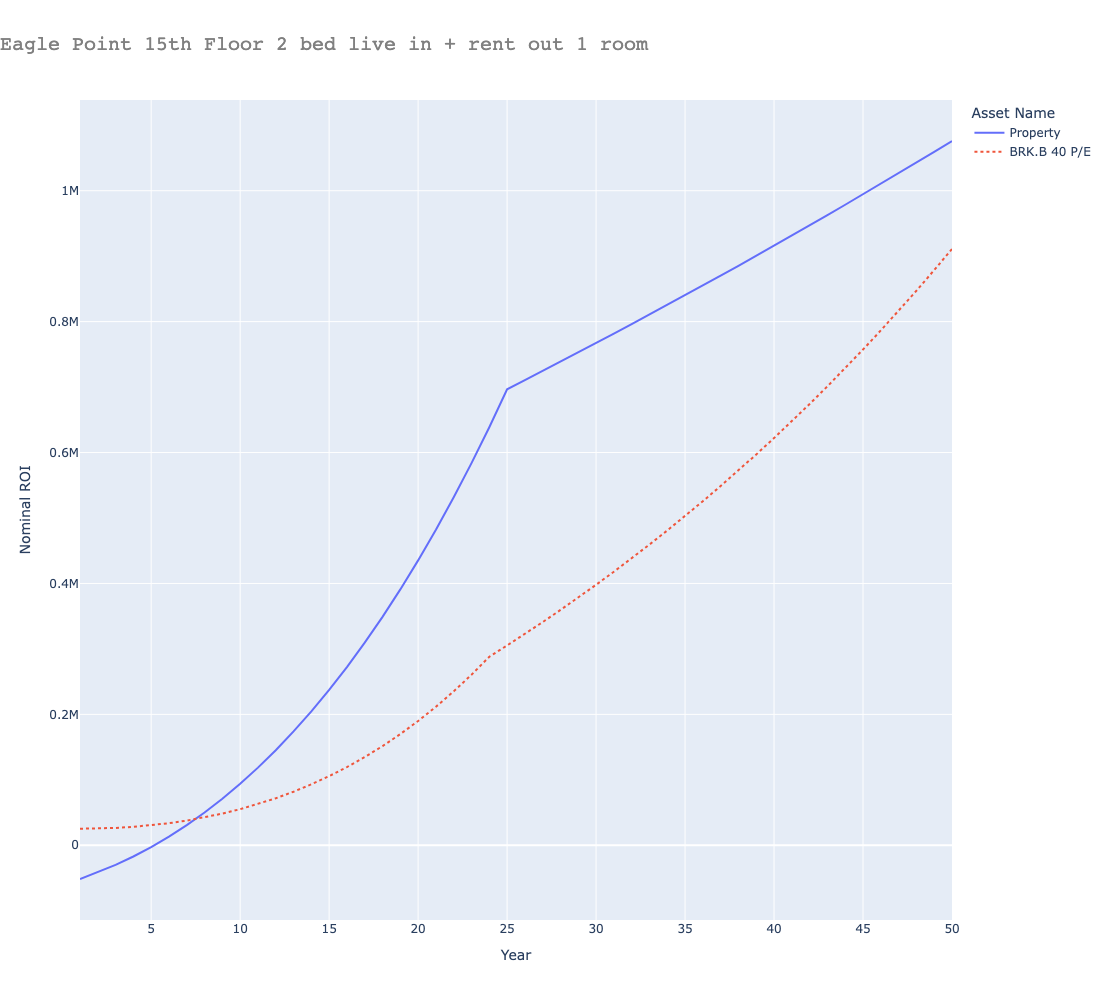

In [5]:
# Eagle Point 15th Floor 2 bed live in + rent out 1 room
property_price = 1050000
length = 25

repayment_mortgage = RepaymentMortgage(
    property_price * 0.75,
    length,
    FIXED_INTEREST_RATE
)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(
    False,
    property_price,
    monthly_gross_rental=7200 / 12,
    rental_tax=0,
    months_occupied_out_of_12=8,
    agency_percentage=LIXING_AGENCY_PERCENTAGE,
    annual_service_charge=7 * 677,
    annual_ground_rent=600,
    mortgage=repayment_mortgage
)

opportunity_cost_property = asset_dictionary[asset_name]

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)

for year in range(2, length):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(
        current_year - previous_year - cost_of_renting_alone * 12
    )
    previous_year = current_year

asset_dictionary["BRK.B 40 P/E"] = HLStock(
    opportunity_cost_property.property_value * 0.25,
    stock_price_to_earnings,
    yearly_principle_repayments
)

(headers, table, graph_source) = generate_header_table_and_graph_source(
    asset_dictionary
)

fig = px.line(
    graph_source,
    x='Year',
    y='Nominal ROI',
    color='Asset Name',
    line_dash='Asset Name',
    title='Eagle Point 15th Floor 2 bed live in + rent out 1 room',
    width=1000,
    height=1000
)

fig.update_layout(
    title_font_size=20,
    title_font_family='Courier',
    title_font_color='gray',
    title_x=0
)

fig.show()

[np.float64(23874.771075978086), np.float64(24636.376273301812), np.float64(25422.27667642008), np.float64(26233.247302397795), np.float64(27070.087891344287), np.float64(27933.62369507854), np.float64(28824.706290951523), np.float64(29744.214421632932), np.float64(30693.05486168299), np.float64(31672.163311770622), np.float64(32682.50532141619), np.float64(33725.07724116923), np.float64(34800.907205162686), np.float64(35911.05614500737), np.float64(37056.6188360331), np.float64(38238.72497690254), np.float64(39458.54030366562), np.float64(40717.26773935277), np.float64(42016.14858023799), np.float64(43356.46371994761), np.float64(44739.53491261287), np.float64(46166.72607632482), np.float64(47639.44463815971), np.float64(49159.14292211691)]


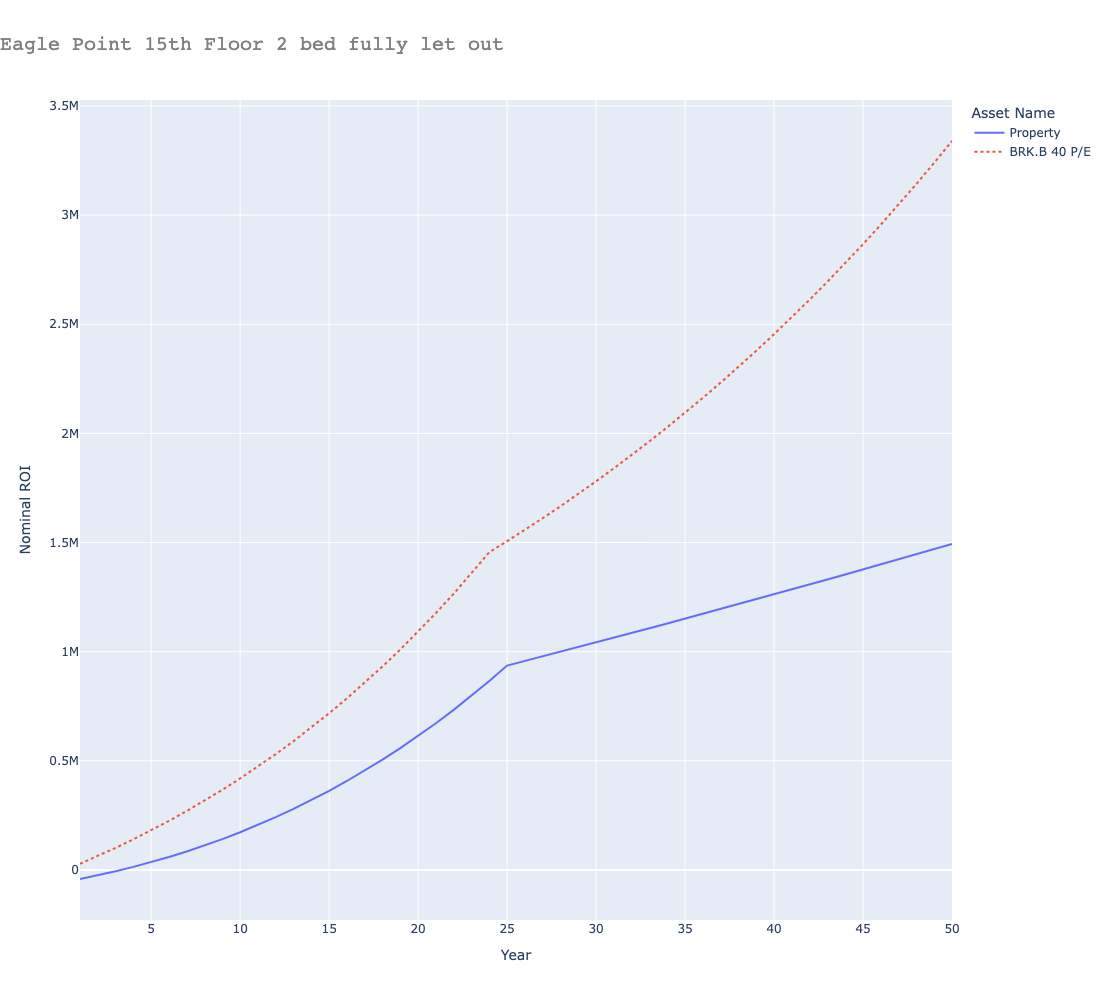

In [6]:
# Eagle Point 15th Floor 2 bed fully let out
property_price = 1050000

repayment_mortgage = RepaymentMortgage(
    property_price * 0.85,
    25,
    FIXED_INTEREST_RATE
)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(
    False,
    property_price,
    monthly_gross_rental=3300,
    rental_tax=0.45,
    months_occupied_out_of_12=8,
    agency_percentage=LIXING_AGENCY_PERCENTAGE,
    annual_service_charge=7 * 456,
    annual_ground_rent=600,
    mortgage=repayment_mortgage
)

opportunity_cost_property = asset_dictionary[asset_name]
opportunity_cost_property.will_you_live_in_this = False

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)

for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(current_year - previous_year)
    previous_year = current_year

print(yearly_principle_repayments)

asset_dictionary["BRK.B 40 P/E"] = HLStock(
    opportunity_cost_property.property_value * 0.25,
    stock_price_to_earnings,
    yearly_principle_repayments
)

(headers, table, graph_source) = generate_header_table_and_graph_source(
    asset_dictionary
)

fig = px.line(
    graph_source,
    x='Year',
    y='Nominal ROI',
    color='Asset Name',
    line_dash='Asset Name',
    title='Eagle Point 15th Floor 2 bed fully let out',
    width=1000,
    height=1000
)

fig.update_layout(
    title_font_size=20,
    title_font_family='Courier',
    title_font_color='gray',
    title_x=0
)

fig.show()

[np.float64(15575.445892423788), np.float64(-15127.697383607872), np.float64(-14614.990930144973), np.float64(-14085.92914081661), np.float64(-13539.99028040866), np.float64(-12976.635970353731), np.float64(-12395.310657808048), np.float64(-11795.441067792184), np.float64(-11176.435637855), np.float64(-10537.683934702567), np.float64(-9878.556052219647), np.float64(-9198.401990285405), np.float64(-8496.55101377549), np.float64(-7772.310991114937), np.float64(-7024.967711731559), np.float64(-6253.784181735828), np.float64(-5457.99989713321), np.float64(-4636.83009385172), np.float64(-3789.4649738455773), np.float64(-2915.0689065112383), np.float64(-2012.7796046289732), np.float64(-1081.707274016575), np.float64(-120.93373605771922), np.float64(870.48847776209)]


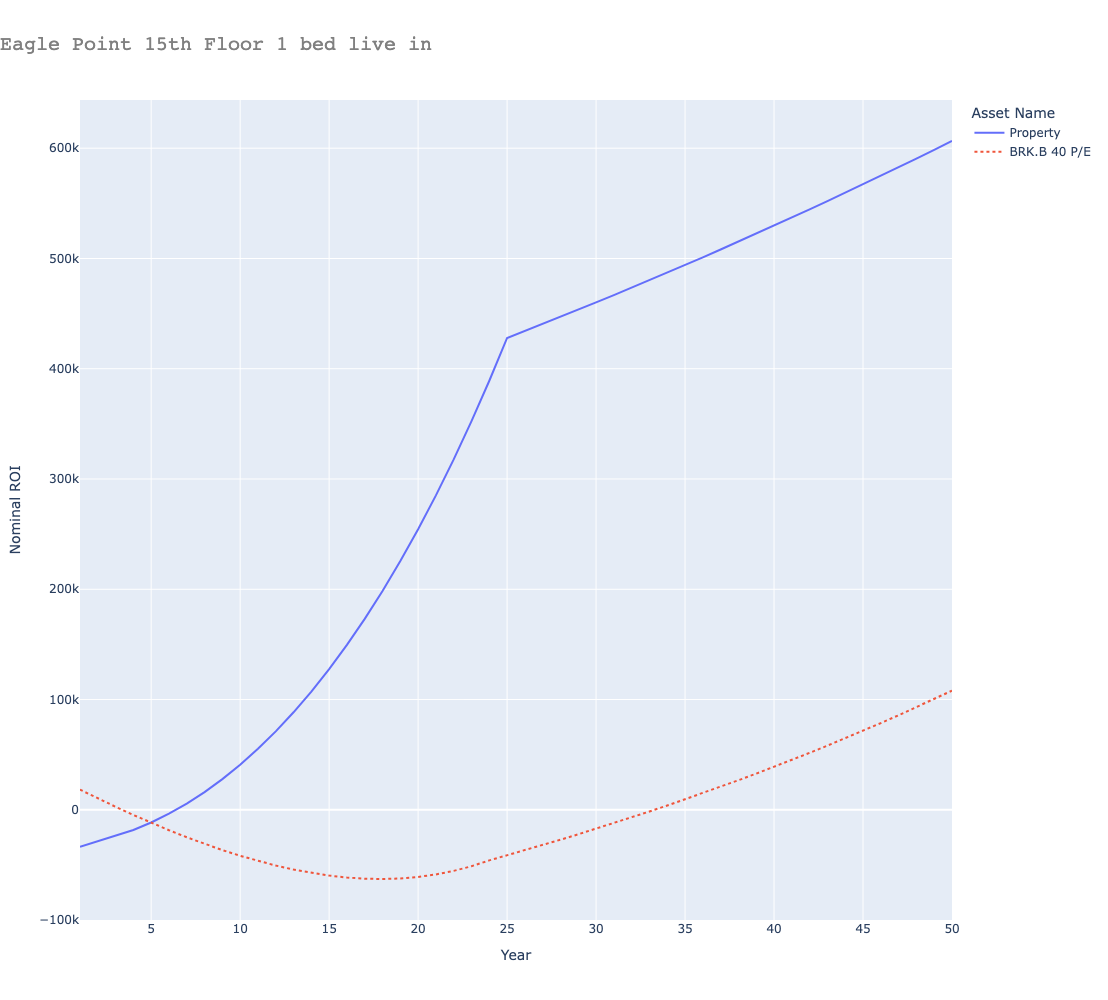

In [7]:
# Eagle Point 15th Floor 1 bed live in
property_price = 685000
cost_of_renting_alone = 2600

repayment_mortgage = RepaymentMortgage(
    property_price * 0.85,
    25,
    FIXED_INTEREST_RATE
)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(
    False,
    property_price,
    monthly_gross_rental=0,
    rental_tax=0,
    months_occupied_out_of_12=8,
    agency_percentage=LIXING_AGENCY_PERCENTAGE,
    annual_service_charge=7 * 603,
    annual_ground_rent=600,
    mortgage=repayment_mortgage
)

opportunity_cost_property = asset_dictionary[asset_name]

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)

for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(
        current_year - previous_year - cost_of_renting_alone * 12
    )
    previous_year = current_year

print(yearly_principle_repayments)

asset_dictionary["BRK.B 40 P/E"] = HLStock(
    opportunity_cost_property.property_value * 0.25,
    stock_price_to_earnings,
    yearly_principle_repayments
)

(headers, table, graph_source) = generate_header_table_and_graph_source(
    asset_dictionary
)

fig = px.line(
    graph_source,
    x='Year',
    y='Nominal ROI',
    color='Asset Name',
    line_dash='Asset Name',
    title='Eagle Point 15th Floor 1 bed live in',
    width=1000,
    height=1000
)

fig.update_layout(
    title_font_size=20,
    title_font_family='Courier',
    title_font_color='gray',
    title_x=0
)

fig.show()

[np.float64(15575.445892423788), np.float64(16072.302616392128), np.float64(16585.009069855027), np.float64(17114.07085918339), np.float64(17660.00971959134), np.float64(18223.36402964627), np.float64(18804.689342191952), np.float64(19404.558932207816), np.float64(20023.564362145), np.float64(20662.316065297433), np.float64(21321.443947780353), np.float64(22001.598009714595), np.float64(22703.44898622451), np.float64(23427.689008885063), np.float64(24175.03228826844), np.float64(24946.215818264172), np.float64(25742.00010286679), np.float64(26563.16990614828), np.float64(27410.535026154423), np.float64(28284.93109348876), np.float64(29187.220395371027), np.float64(30118.292725983425), np.float64(31079.06626394228), np.float64(32070.48847776209)]


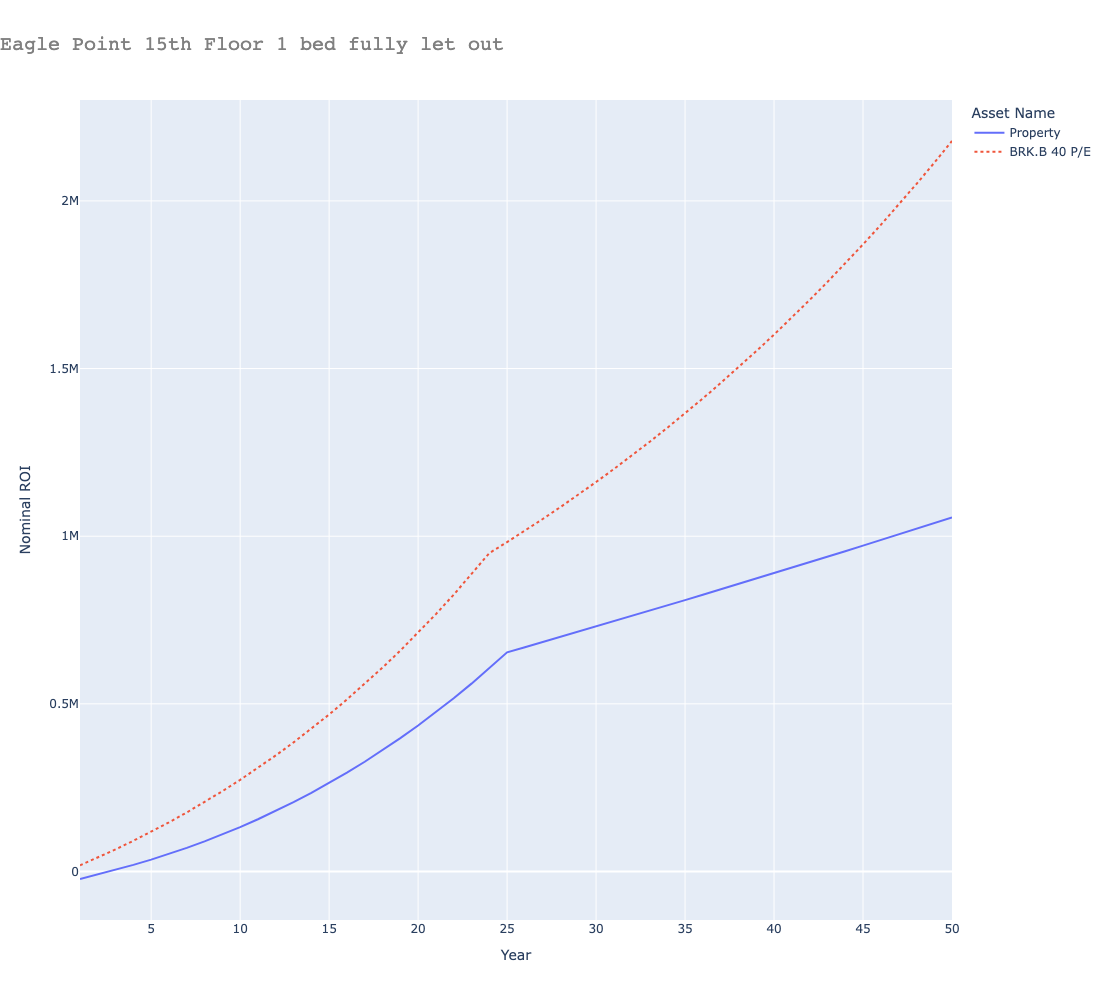

In [8]:
# Eagle Point 15th Floor 1 bed fully let out
property_price = 685000

repayment_mortgage = RepaymentMortgage(
    property_price * 0.85,
    25,
    FIXED_INTEREST_RATE
)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(
    False,
    property_price,
    monthly_gross_rental=2600,
    rental_tax=0.45,
    months_occupied_out_of_12=8,
    agency_percentage=LIXING_AGENCY_PERCENTAGE,
    annual_service_charge=7 * 603,
    annual_ground_rent=600,
    mortgage=repayment_mortgage
)

opportunity_cost_property = asset_dictionary[asset_name]
opportunity_cost_property.will_you_live_in_this = False

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)

for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(current_year - previous_year)
    previous_year = current_year

print(yearly_principle_repayments)

asset_dictionary["BRK.B 40 P/E"] = HLStock(
    opportunity_cost_property.property_value * 0.25,
    stock_price_to_earnings,
    yearly_principle_repayments
)

(headers, table, graph_source) = generate_header_table_and_graph_source(
    asset_dictionary
)

fig = px.line(
    graph_source,
    x='Year',
    y='Nominal ROI',
    color='Asset Name',
    line_dash='Asset Name',
    title='Eagle Point 15th Floor 1 bed fully let out',
    width=1000,
    height=1000
)

fig.update_layout(
    title_font_size=20,
    title_font_family='Courier',
    title_font_color='gray',
    title_x=0
)

fig.show()

[np.float64(14846.496299347727), np.float64(-15879.900468703123), np.float64(-15391.189293654752), np.float64(-14886.888232122343), np.float64(-14366.499966727017), np.float64(-13829.511315665659), np.float64(-13275.392726635386), np.float64(-12703.597754615039), np.float64(-12113.562522987253), np.float64(-11504.705167470587), np.float64(-10876.425262312841), np.float64(-10228.10322818064), np.float64(-9559.099721159611), np.float64(-8868.755002264574), np.float64(-8156.388286836853), np.float64(-7421.297073186957), np.float64(-6662.7564498215215), np.float64(-5880.018380570924), np.float64(-5072.31096691126), np.float64(-4238.837686755578), np.float64(-3378.7766089631477), np.float64(-2491.2795827890513), np.float64(-1575.4714014800265), np.float64(-630.4489391872194)]


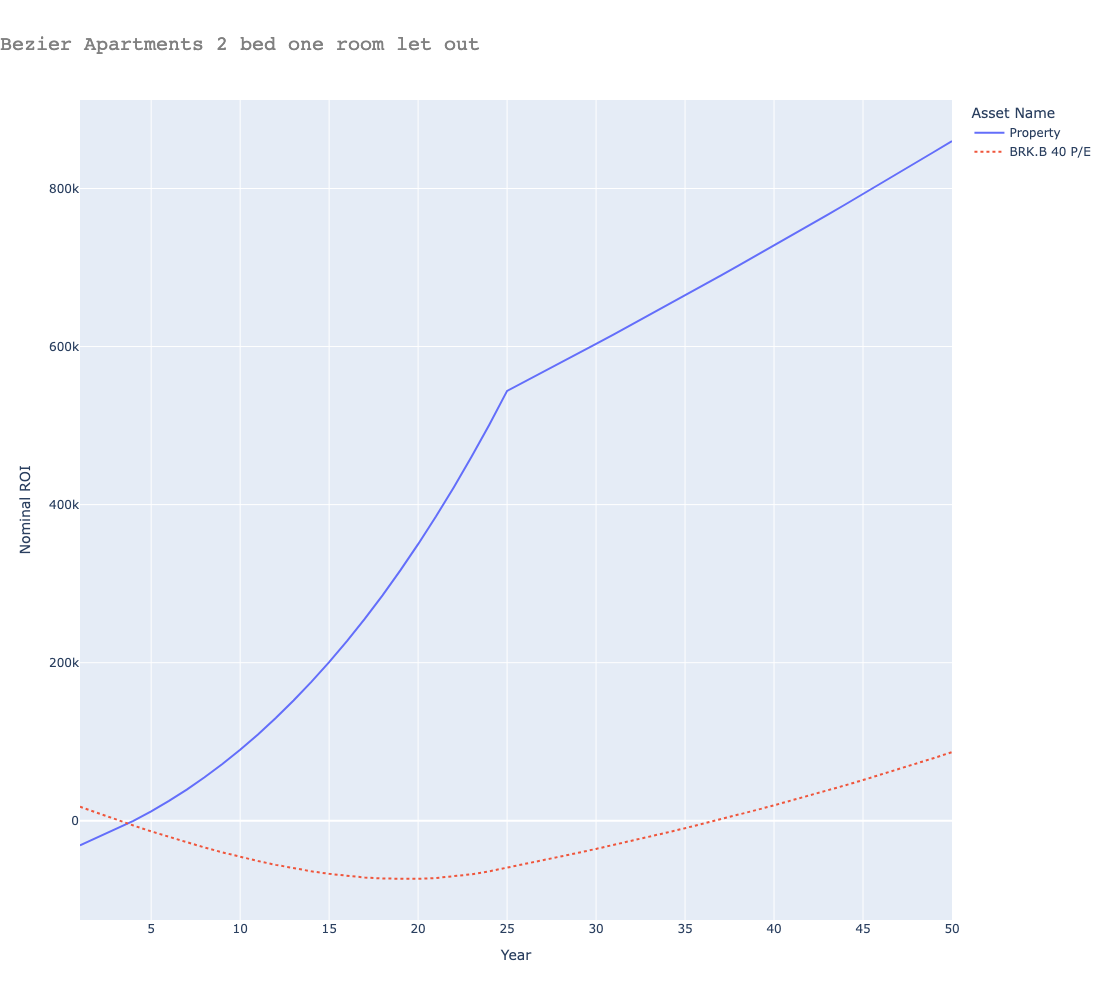

In [9]:
# Bezier Apartments 2 bed one room let out
property_price = 740000

repayment_mortgage = RepaymentMortgage(
    property_price * 0.75,
    25,
    FIXED_INTEREST_RATE
)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(
    False,
    property_price,
    monthly_gross_rental=700,
    rental_tax=0,
    months_occupied_out_of_12=8,
    agency_percentage=LIXING_AGENCY_PERCENTAGE,
    annual_service_charge=7 * 677,
    annual_ground_rent=600,
    mortgage=repayment_mortgage
)

opportunity_cost_property = asset_dictionary[asset_name]

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)

for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(
        current_year - previous_year - cost_of_renting_alone * 12
    )
    previous_year = current_year

print(yearly_principle_repayments)

asset_dictionary["BRK.B 40 P/E"] = HLStock(
    opportunity_cost_property.property_value * 0.25,
    stock_price_to_earnings,
    yearly_principle_repayments
)

(headers, table, graph_source) = generate_header_table_and_graph_source(
    asset_dictionary
)

fig = px.line(
    graph_source,
    x='Year',
    y='Nominal ROI',
    color='Asset Name',
    line_dash='Asset Name',
    title='Bezier Apartments 2 bed one room let out',
    width=1000,
    height=1000
)

fig.update_layout(
    title_font_size=20,
    title_font_family='Courier',
    title_font_color='gray',
    title_x=0
)

fig.show()

[np.float64(9529.845597554278), np.float64(-21366.15232788376), np.float64(-21988.452587143274), np.float64(-22628.825824673087), np.float64(-23287.795216480125), np.float64(-23965.89902732584), np.float64(-24663.691044040745), np.float64(-25381.741021221125), np.float64(-26120.635139659826), np.float64(-26880.976477872617), np.float64(-27663.385497092095), np.float64(-28468.50054011194), np.float64(-29296.978344374016), np.float64(-30149.494569702954), np.float64(-31026.744341104277), np.float64(-31929.442807052066), np.float64(-32858.32571370766), np.float64(-33814.14999551882), np.float64(-34797.694382666145), np.float64(-35809.76002583213), np.float64(-36851.171138785845), np.float64(-37922.77565928671), np.float64(-39025.44592882671), np.float64(-40160.07939174542)]


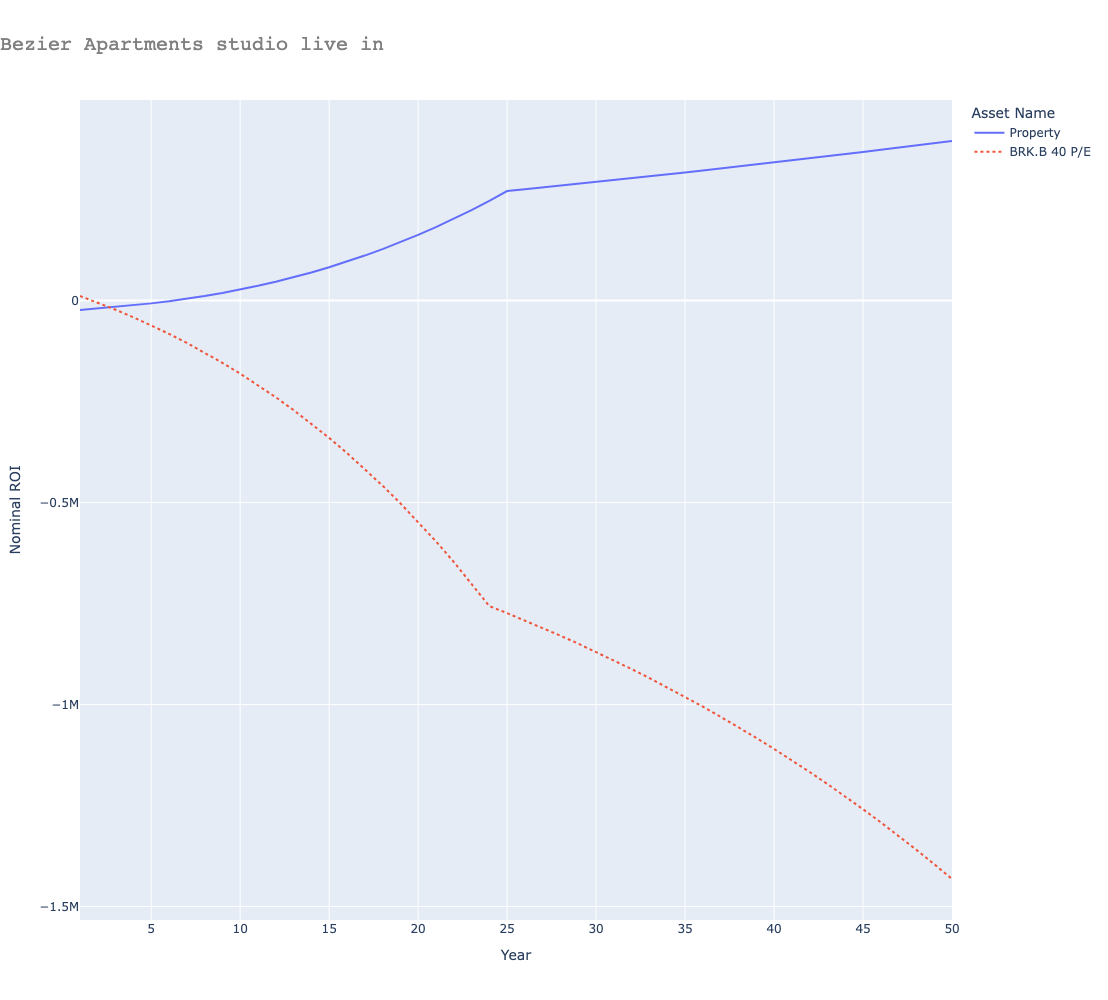

In [10]:
# Bezier Apartments studio live in (with rent inflation)
property_price = 475000

repayment_mortgage = RepaymentMortgage(
    property_price * 0.75,
    25,
    FIXED_INTEREST_RATE
)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(
    False,
    property_price,
    monthly_gross_rental=0,
    rental_tax=0,
    months_occupied_out_of_12=8,
    agency_percentage=LIXING_AGENCY_PERCENTAGE,
    annual_service_charge=7 * 456,
    annual_ground_rent=600,
    mortgage=repayment_mortgage
)

opportunity_cost_property = asset_dictionary[asset_name]

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)

original_cost_of_renting_alone = cost_of_renting_alone
rent_inflation = 0.03

for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(
        current_year - previous_year - cost_of_renting_alone * 12
    )
    cost_of_renting_alone *= 1 + rent_inflation
    previous_year = current_year

cost_of_renting_alone = original_cost_of_renting_alone

print(yearly_principle_repayments)

asset_dictionary["BRK.B 40 P/E"] = HLStock(
    opportunity_cost_property.property_value * 0.25,
    stock_price_to_earnings,
    yearly_principle_repayments
)

(headers, table, graph_source) = generate_header_table_and_graph_source(
    asset_dictionary
)

fig = px.line(
    graph_source,
    x='Year',
    y='Nominal ROI',
    color='Asset Name',
    line_dash='Asset Name',
    title='Bezier Apartments studio live in',
    width=1000,
    height=1000
)

fig.update_layout(
    title_font_size=20,
    title_font_family='Courier',
    title_font_color='gray',
    title_x=0
)

fig.show()

[np.float64(9529.845597554278), np.float64(9833.84767211624), np.float64(10147.547412856726), np.float64(10471.254175326914), np.float64(10805.287183519875), np.float64(11149.975844674162), np.float64(11505.66007411926), np.float64(11872.690630483674), np.float64(12251.429461596126), np.float64(12642.250061421015), np.float64(13045.537838380347), np.float64(13461.690495424671), np.float64(13891.118422228697), np.float64(14334.245099897846), np.float64(14791.507518584549), np.float64(15263.35660842742), np.float64(15750.257684236218), np.float64(16252.690904363379), np.float64(16771.15174421252), np.float64(17306.15148485289), np.float64(17858.217717219726), np.float64(18427.89486239903), np.float64(19015.744708509592), np.float64(19622.346964710974)]


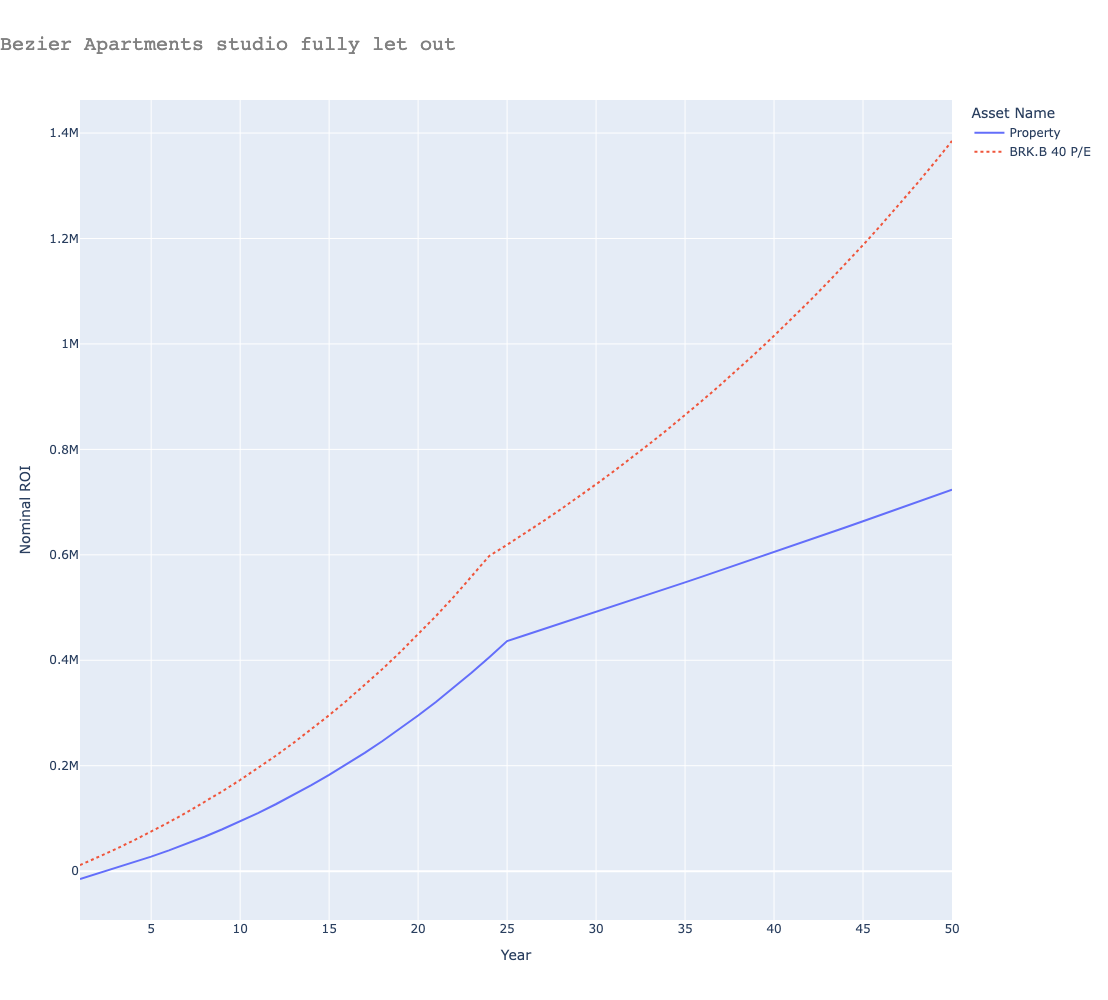

In [11]:
# Bezier Apartments studio fully let out
property_price = 475000

repayment_mortgage = RepaymentMortgage(
    property_price * 0.75,
    25,
    FIXED_INTEREST_RATE
)

asset_name = "Property"
asset_dictionary[asset_name] = LeaseholdProperty(
    False,
    property_price,
    monthly_gross_rental=1900,
    rental_tax=0.45,
    months_occupied_out_of_12=8,
    agency_percentage=LIXING_AGENCY_PERCENTAGE,
    annual_service_charge=7 * 456,
    annual_ground_rent=600,
    mortgage=repayment_mortgage
)

opportunity_cost_property = asset_dictionary[asset_name]
opportunity_cost_property.will_you_live_in_this = False

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)

for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(current_year - previous_year)
    previous_year = current_year

print(yearly_principle_repayments)

asset_dictionary["BRK.B 40 P/E"] = HLStock(
    opportunity_cost_property.property_value * 0.25,
    stock_price_to_earnings,
    yearly_principle_repayments
)

(headers, table, graph_source) = generate_header_table_and_graph_source(
    asset_dictionary
)

fig = px.line(
    graph_source,
    x='Year',
    y='Nominal ROI',
    color='Asset Name',
    line_dash='Asset Name',
    title='Bezier Apartments studio fully let out',
    width=1000,
    height=1000
)

fig.update_layout(
    title_font_size=20,
    title_font_family='Courier',
    title_font_color='gray',
    title_x=0
)

fig.show()

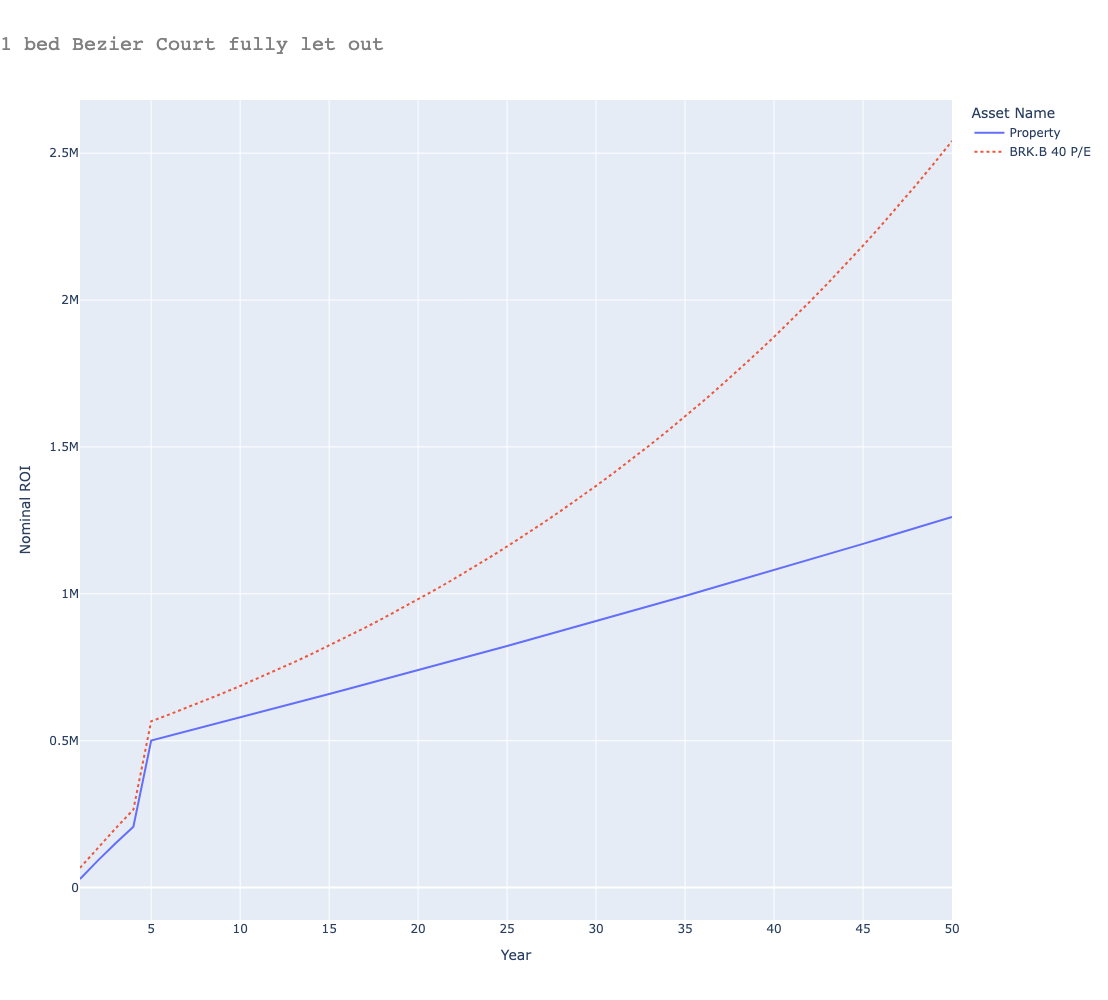

In [12]:
# 1 bed Bezier Court fully let out
property_price = 690000
repayment_mortgage = RepaymentMortgage(
    690000 * 0.75,
    25,
    FIXED_INTEREST_RATE,
    {1 * 12: 0.1, 2 * 12: 0.1, 3 * 12: 0.1, 4 * 12: 0.1, 5 * 12: 1}
)

asset_dictionary["Property"] = LeaseholdProperty(
    False,
    property_price,
    monthly_gross_rental=700 * 4.3,
    rental_tax=0.45,
    months_occupied_out_of_12=8,
    agency_percentage=LIXING_AGENCY_PERCENTAGE,
    annual_service_charge=7 * 677,
    annual_ground_rent=600,
    mortgage=repayment_mortgage
)

opportunity_cost_property = asset_dictionary["Property"]
opportunity_cost_property.will_you_live_in_this = False
yearly_principle_repayment = opportunity_cost_property.mortgage.principle / 25

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year)

for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(current_year - previous_year)
    previous_year = current_year

asset_dictionary["BRK.B 40 P/E"] = HLStock(
    opportunity_cost_property.property_value * 0.25,
    stock_price_to_earnings,
    yearly_principle_repayments
)

(headers, table, graph_source) = generate_header_table_and_graph_source(
    asset_dictionary
)

fig = px.line(
    graph_source,
    x='Year',
    y='Nominal ROI',
    color='Asset Name',
    line_dash='Asset Name',
    title='1 bed Bezier Court fully let out',
    width=1000,
    height=1000
)

fig.update_layout(
    title_font_size=20,
    title_font_family='Courier',
    title_font_color='gray',
    title_x=0
)

fig.show()

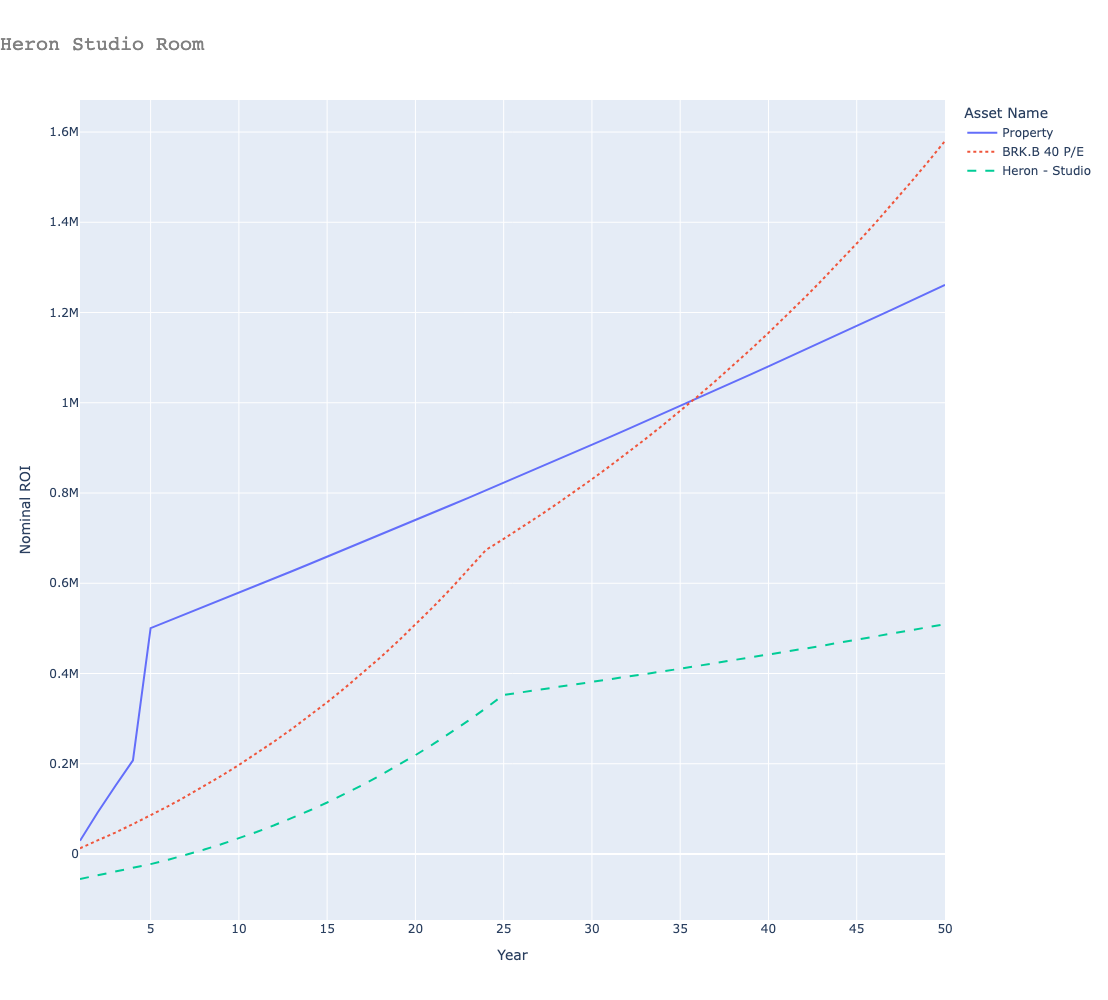

In [13]:
# Heron Studio Room
asset_dictionary["Heron - Studio"] = generateLeaseholdPropertyForecast(
    True,
    heron_property_price,
    ltv_percentage=LTV_PERCENTAGE,
    monthly_gross_rental=0,
    rental_tax=0,
    months_occupied_out_of_12=10,
    agency_percentage=0,
    annual_service_charge=3967,
    annual_ground_rent=300,
    mortgage_searcher=mortgageFactory,
    MortgageClass=RepaymentMortgage,
    length=25,
    interest_rate=INTEREST_RATE
)

opportunity_cost_property = asset_dictionary["Heron - Studio"]
asset_dictionary["Heron - Studio"].will_you_live_in_this = False

yearly_principle_repayments = []
previous_year = opportunity_cost_property.mortgage.total_principle_paid(1)
yearly_principle_repayments.append(previous_year - cost_of_renting_alone)

for year in range(2, 25):
    current_year = opportunity_cost_property.mortgage.total_principle_paid(year)
    yearly_principle_repayments.append(
        current_year - previous_year - cost_of_renting_alone
    )
    previous_year = current_year

asset_dictionary["BRK.B 40 P/E"] = HLStock(
    opportunity_cost_property.property_value * 0.25,
    stock_price_to_earnings,
    yearly_principle_repayments
)

(headers, table, graph_source) = generate_header_table_and_graph_source(
    asset_dictionary
)

fig = px.line(
    graph_source,
    x='Year',
    y='Nominal ROI',
    color='Asset Name',
    line_dash='Asset Name',
    title='Heron Studio Room',
    width=1000,
    height=1000
)

fig.update_layout(
    title_font_size=20,
    title_font_family='Courier',
    title_font_color='gray',
    title_x=0
)

fig.show()

In [16]:
def calculate_year_profit(asset, year):
    """
    Calculate and print profit for a specific year.
    
    Args:
        asset: Asset object to analyze
        year: Year to calculate profit for
    """
    net_year_profit = asset.calculate_profits(year) - asset.calculate_profits(year - 1)
    per_month = net_year_profit / 12
    print(f"Year {year}: {net_year_profit:.2f}. Per Month: {per_month:.2f}")


# Analyze Heron property profitability
heron = asset_dictionary["Heron - Studio"]

calculate_year_profit(heron, 2)
calculate_year_profit(heron, 3)
calculate_year_profit(heron, 5)
calculate_year_profit(heron, 10)
calculate_year_profit(heron, 26)

# Calculate ROI for year 26
roi_year_26 = (
    (heron.calculate_profits(26) - heron.calculate_profits(25))
    / (heron.property_value + heron.buy_expenses)
)
print(f"\nROI Year 26: {roi_year_26:.4f}")
print(f"Profit Year 26: {heron.calculate_profits(26) - heron.calculate_profits(25):.2f}")

Year 2: -11029.56. Per Month: -919.13
Year 3: -10683.57. Per Month: -890.30
Year 5: -9964.49. Per Month: -830.37
Year 10: -7997.34. Per Month: -666.44
Year 26: 0.00. Per Month: 0.00

ROI Year 26: 0.0000
Profit Year 26: 0.00
